<a href="https://colab.research.google.com/github/JCLC9027/Proyecto_integrador_18/blob/main/Avance2_18equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

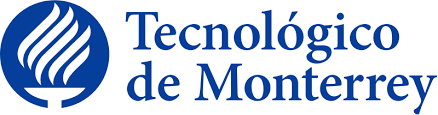

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Asesor: Luis Eduardo Falcón Morales
## **Avance 2. Ingeniería de características**
###**Equipo 18:**
###**A01793052 - Juan Carlos Lopez Cruz**


## **Website description**:

ConsumerAffairs is a rapidly growing online marketplace where each month millions of consumers research purchases, connect with brands, transact, write reviews and stay up to date on important consumer news.

Brands utilize our software-as-a-service platform to connect with customers, collect reviews and generate sales.

ConsumerAffairs has a creative, driven and fast-paced entrepreneurial environment. We are looking for teammates that want to win, are self-motivated, high performing and who yearn to build something big.

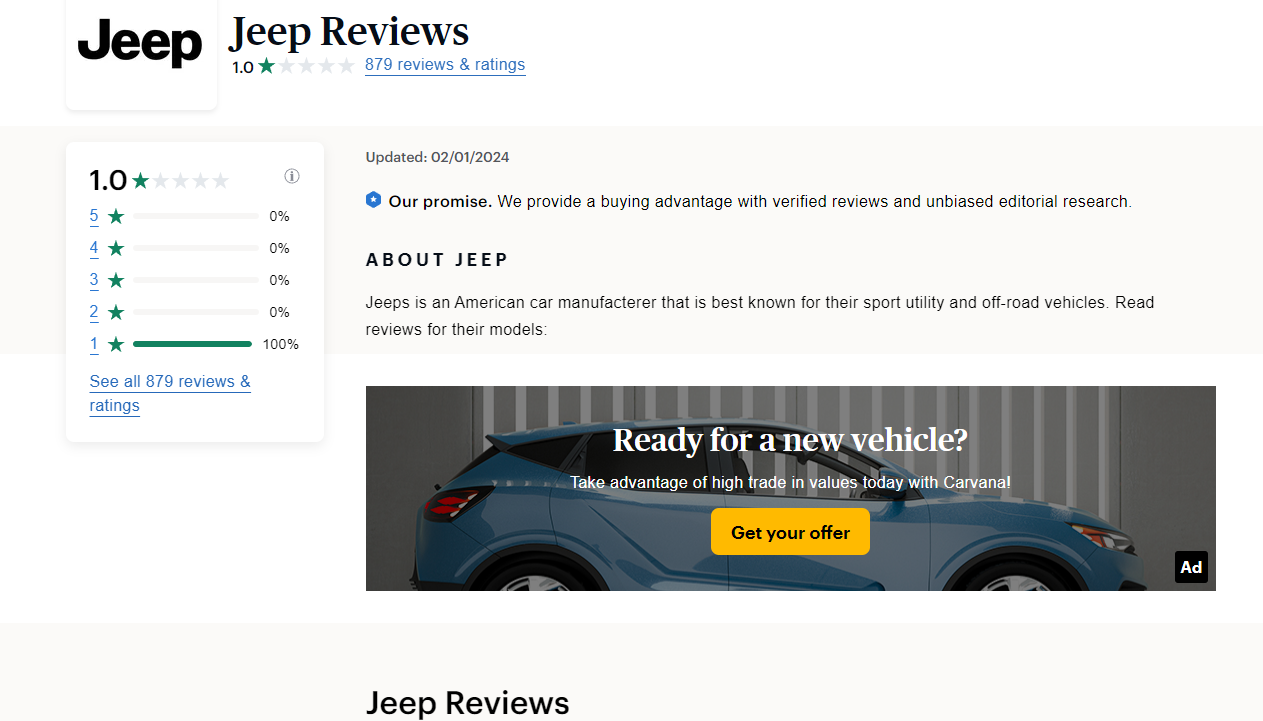

## **Libraries to install**

In [29]:
# Just run this if you have not download the Fasttext embbedbings Model.
!pip install fasttext # just run once and then return it as a comment
fasttext.util.download_model('en', if_exists='ignore') # just run once and then return it as a comment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199775 sha256=29e61978266e6b944f8f12f4ddf7e0aea5bfacd48c525a3c7283b4229017e184
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext



'cc.en.300.bin'

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00


## **Libraries to be used**

In [26]:
import requests
from bs4 import BeautifulSoup as soup
from random import randint
from time import sleep
from datasets import Dataset, load_dataset, DatasetDict
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF Matrix

import fasttext
import fasttext.util



# **Web Scrapping part**

Web scraping refers to the extraction of data from a website. This information is collected and then exported into a format that is more useful for the user. Be it a spreadsheet or an API.


In [4]:
url = 'https://www.consumeraffairs.com/automotive/jeep.htm?page=2#scroll_to_reviews=true'
#url = 'https://www.consumeraffairs.com/automotive/jeep.htm#scroll_to_reviews=true'
html = requests.get(url, headers={"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"})
print(html.status_code) # the outoput  "200" only  is the status if there is a response correct.

200


## **1-First let's collect all the links of the opinions:**

The website only shows 7 pages with comments realted to Jeep brand

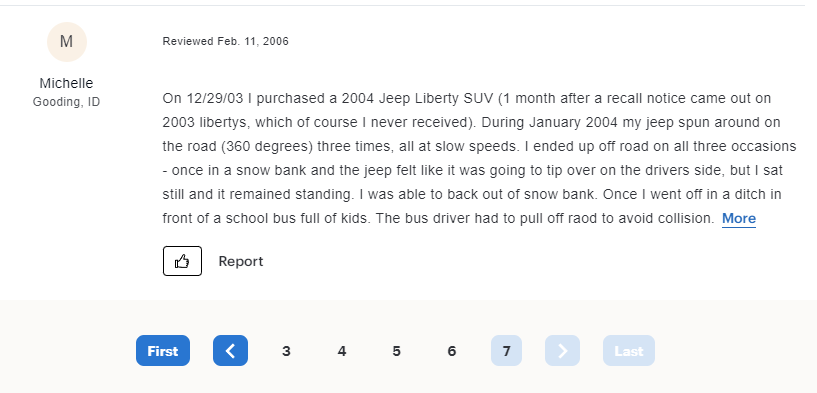

In [5]:
links = []

max_or_num = 8  # This is the value maximum that link shows of pages


reviews_x_pages = 1    # The pages are changing 1 by 1.

for k in range(1, max_or_num, reviews_x_pages):
  a = url
  if k == 1:
    a=a.replace("page=2","")     # for the first page there is not page number
  else:
    ss = str(k)  # convertimos a string el valor numérico.
    a=a.replace("2",ss)
  links.append(a)


links

['https://www.consumeraffairs.com/automotive/jeep.htm?#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=2#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=3#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=4#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=5#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=6#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=7#scroll_to_reviews=true']

## **2- The next step is to extract the comments of the reviewd from each page.**

**Considerations:**


1- Some comments do not have rating  but these start from page 5.

2- Some comments do not show complet if the user does not clik on More button.


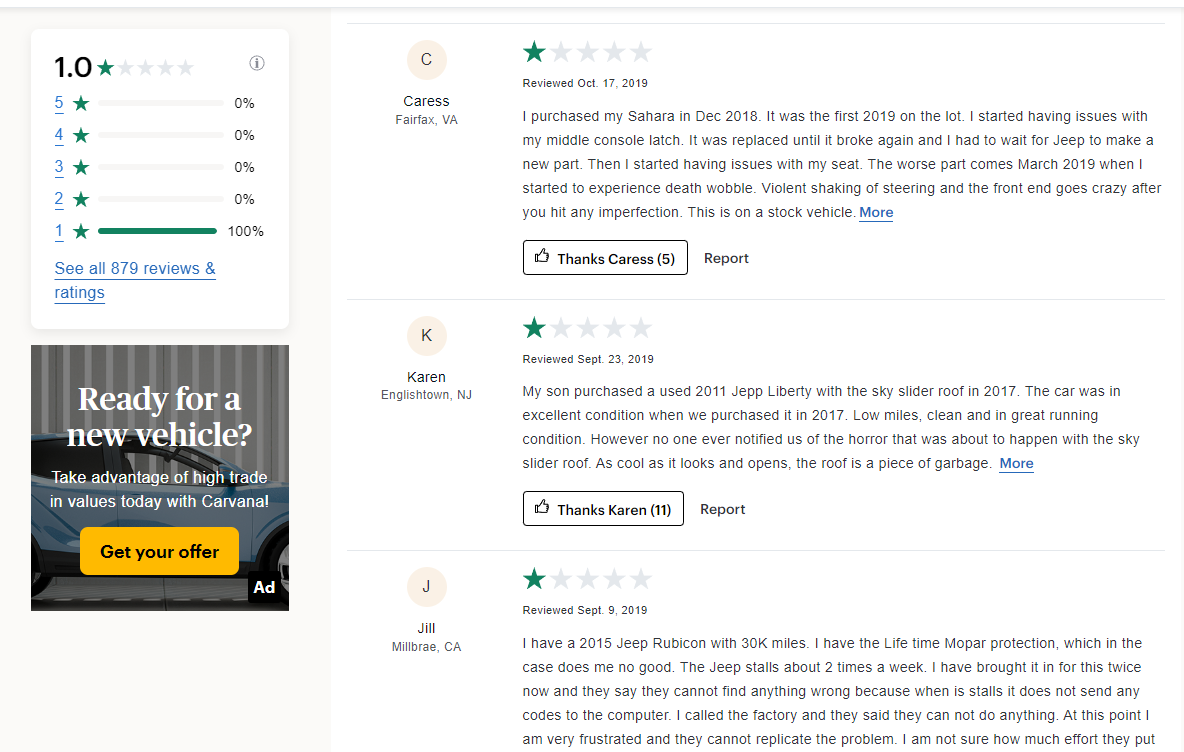

In [7]:
# The following Code is to extract the comments from https://www.consumeraffairs.com/automotive/jeep.htm

reviews = [] # This list will include the comments from web scrapping in the first run
review_text= [] # This list that we will use to storage the final comments
stars =[] # This list will storage the raiting.


numpages = int( max_or_num / reviews_x_pages )  # The number of pages is 7 but for start in 0 to 8

for link in links[0:numpages]:
  print(link)
# This code check the status of the status if there is a response correct.
  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36' }
  html2 = requests.get(link, headers=headers)
  #print(html2.status_code) ####

  sleep(randint(1,5))   # sleep intervals are included so that calls are not continuously made to the page
                         # and that by detecting this continuous activity, it can be detected as suspicious activity by the server
                         # and can automatically block us for it.
  bsobj1 = soup(html2.content,'lxml')   # BeautifulSoup library object to carry out our task.

  # We extract comments in either of the following two ways:
  # We include some Print just to visualize how the process is carried out:

  # The following code is to extract the text of the comments thad button More shows once the user press click
  reviews2 = [] # This list will storage per page the text of comments that button "More" shows
  for review2 in bsobj1.findAll('div', {'class' : 'js-collapsed rvw__all-text'}): # class that return the text of More button
     # print(review2.text)
      reviews2.append(review2.text.strip())
#####################

  sleep(randint(1,5))
  bsobj2 = soup(html2.content,'lxml')

  i=0 # This variable is to pass the remaining text from buttom More to the comments.
  for review in bsobj2.findAll('div', {'class' : 'rvw__top-text'}): #class tha provide the text form the pages
      if "      More" in review.text: # If the comment has the button More
        review_text =review.text.replace("                                  More", reviews2[i]) #The remaing text replace the More word in the comment
        i=i+1 # This will increase until the final remaining text per comment.
      else: # if the comments does not have the button More just extract the text.
        review_text=review.text
      print(review_text)
      reviews.append(review_text.strip()) #Storage all in the list reviews

  sleep(randint(1,5))
  bsobj3 = soup(html2.content,'lxml')

   # Let's also extract the ratings (stars):
   # In particular in this case we will extract the entire string where the
   # rating of the hotel by the user and from there through regex you can
   # Easily perform rating extraction:
  for cal in bsobj3.findAll('div', {'class' : 'rvw__hdr-stat'}):
    cal= cal.find("div")["class"][2]
    cal=int(cal[-1])
    print(cal)
    #  Aquí puedes incluir tu regex para extraer solo la calificación numérica.
    stars.append(cal)

https://www.consumeraffairs.com/automotive/jeep.htm?#scroll_to_reviews=true
So I went in to replace the hose radiator outlet 2 weeks ago on my compass tailhawk and still no part is available. If you're going to create a part made specifically for Jeep then at least have the decency to have the part available. They had to know this would happen because they used plastic for a part next to the engine which, of course, is going to melt. I've been a Jeep lover for my whole life and now will probably never purchase again because they no longer keep the customers in mind, it's all about how to create $ for the company. Let's create a part that can't be purchased by any other manufacturer and not make enough inventory for the part.
      This must be an ongoing problem because it's gonna be a month until the part will be ready. How do they expect people to function or be able to go to work; when that is the only means of transportation they have? If you're curious the part number is **. Also,

In [8]:
print('Qty of comments:', len(reviews))
print('Qty of rates:', len(stars))

Qty of comments: 879
Qty of rates: 510


** 879 comments were found as the website says.**

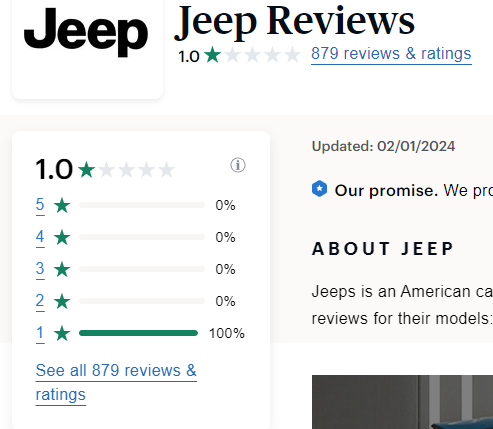

**Note:** In Page 7 there was a comment rated it is recommended to eliminate to make easy the analysis so we will have 509 stars.


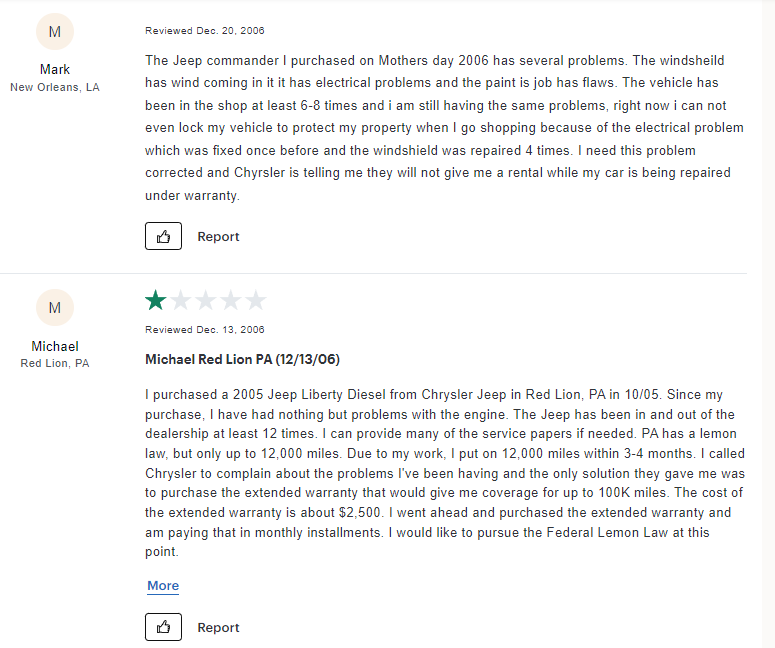

## **3- Validation that comments and rates are according to the website.**

As it was mentioned in the begining of step 2: There are some comments that dont have raiting since page 5.

**Note:** We will use the comments rated and we will use the comments w/o raiting to later use to evaluate the sentiment analizer.

In [9]:
stars=stars[0:509]

In [10]:
reviews_rated = reviews[0:509]
reviews_norated= reviews[509:-1]

In [11]:
reviews_rated[508]

'I took my 2006 Jeep Commander to Odessa,Texas repair shop on June 27 to have the AC fixed.  That went out 60 miles from home on Sunday, June 26. It was in the shop for 15 days. Got it out July 11. \n      I was told two-three days and it would be ready. Fifteen days later, it was ready. No parts had to be ordered for the AC.  One part was ordered for the temp ready inside of jeep on Thursday and received on Monday morning and then it was ready that afternoon.This will be the last time we will buy any brand that you sell.  I had doctor appointments and a lot of errands to do.  It was very hard for family and friends to stop and take time to help me out.  I am very unhappy about this problem and something needs to be done about it.'

**Lets check the last comment rated in the page #5.**

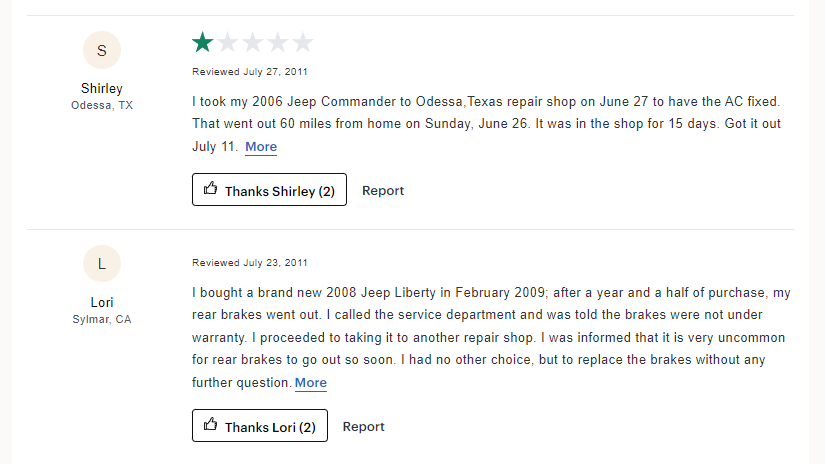

In [12]:
stars[508]

1

In [14]:
reviews_norated[0:-1]

['I bought a brand new 2008 Jeep Liberty in February 2009; after a year and a half of purchase, my rear brakes went out. I called the service department and was told the brakes were not under warranty. I proceeded to taking it to another repair shop. I was informed that it is very uncommon for rear brakes to go out so soon. I had no other choice, but to replace the brakes without any further question.\n      Now after just three-four months later, I began having more issues with the vehicle; smoking in the rear end, oil leaking and the smell of something burning and then the rattling in the rear, which ended with the rear brakes completely locking up on me--leaving me stranded at night, with my six year old son and my 18 month old daughter. I had to have the car towed to the dealership the following day. They had the vehicle for two days, stating it was the rear-end differential that went out. I was at that time asking for a rental car, which the dealership said they did not do. So, I 

## **4- Creation of binary label, dataframe and Storage in cvs file .**

Convert the rates scale (1,2,3,4,5) to binary problem.

In [33]:
ds = Dataset.from_dict({"text": reviews_rated, "labels": [1 if star >= 4 else 0 for star in stars]})
ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 509
})

**Justification:**

When it comes to converting scores from a multi-class classification problem to a binary problem, there are different approaches that can be taken. A common way to approach this situation is to set a threshold to divide ratings into positive and negative.

In this case, if you want to consider ratings between 3 and 4 as 3.5, it is possible to set a threshold at 3.5 to classify the ratings as positive or negative. Any rating equal to or greater than 3.5 would be considered positive, while any rating below 3.5 would be considered negative.

This choice is based on the assumption that a rating of 3.5 is somewhere between positive ratings (greater than 3.5) and negative ratings (less than 3.5). By considering the rating of 3.5 as positive, it is being assumed that comments with a rating close to 3.5 still contain positive elements and should therefore be treated as such.

However, it is important to note that the choice of threshold may depend on the specific context and requirements of the problem. In some cases, it may be more appropriate to adjust the threshold to classify ratings between 3 and 4 as positive or negative. This will depend on the distribution of ratings and how the concept of "positive" and "negative" is defined in the context of the problem at hand. In our case we decided to consider ratings greater than or equal to 4 as positive and those less than 4 as negative.

No rated comments will be storage in a data set with the legend in labels as "NA". Later we can use these comments to test our Model

In [34]:
No_data=["NA" for _ in range(369)]
ds_norated = Dataset.from_dict({"text": reviews_norated, "labels": No_data})
ds_norated

Dataset({
    features: ['text', 'labels'],
    num_rows: 369
})

We will Generate 2 files to storage comments rated and comments no rated related to Jeep brand.

In [39]:
ds.to_pandas().to_csv('./Jeep_comments_rated.csv', index = False, encoding = 'utf8')
ds_norated.to_pandas().to_csv('./Jeep_comments_norated.csv', index = False, encoding = 'utf8')

In [40]:
files.download('Jeep_comments_rated.csv')
files.download('Jeep_comments_norated.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# Calculate the ratio of positive and negative tags
label_count = ds.to_pandas().labels.value_counts()
proportion_negative, proportion_positive = (label_count/len(ds['labels'])).tolist()
# Print the ratio of positive and negative labels
print(f"% of positive comments: {proportion_positive:.2f}")
print(f"% of negative comments: {proportion_negative:.2f}")

% of positive comments: 0.11
% of negative comments: 0.89


In [38]:
label_count

0    451
1     58
Name: labels, dtype: int64

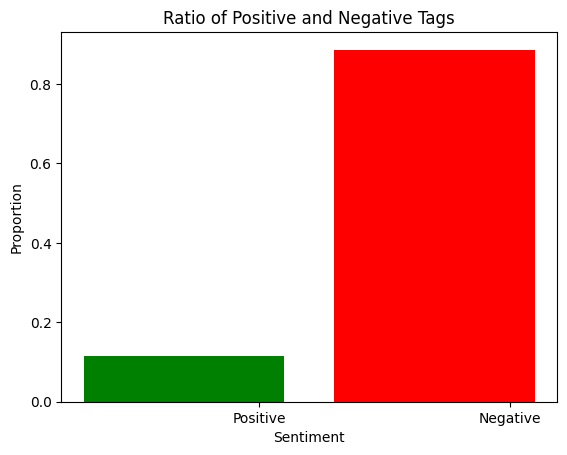

In [78]:
# Plot the proportions
labels = ['Positive', 'Negative']
proportions = [proportion_positive, proportion_negative]

plt.bar(labels, proportions, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks([r + bar_width for r in range(len(labels))], labels)
plt.title('Ratio of Positive and Negative Tags')
plt.show()

## **Conclusions:**

It is observed that the classes are unbalanced and it will be necessary to create synthetic data to balance the classes.

76 positive classes
432 negative classes

In this case we will review the following options:
1- As in this case our data is Text, one option is to use a text generating model to generate synthetic comments with positive classes so that we have enough positive classes to perform the sentiment analysis.

2- The amount of negative data could be reduced but this is not advisable since we would lose data and for sentiment analysis the model may not be as robust.

The solution will be discussed with the advisor to have better feedback regarding this point of the project and look for the best option of these two or consider another one.

# **Load Data from Github**

This code is to load the data base w/o run the webscrapping again

In [3]:
url = 'https://github.com/JCLC9027/Proyecto_integrador_18/raw/main/Jeep_comments_rated.csv'
data = pd.read_csv(url)
print(data.head())

                                                text  labels
0  So I went in to replace the hose radiator outl...       0
1  I was so excited to buy a Jeep but turns out i...       0
2  The 2015 Jeep Wrangler Willy I purchased is a ...       0
3  I’m a mail carrier from the Dakotas.. so I pur...       0
4  My name is Deborah. I purchased a 22 Compass i...       0


In [4]:
X=data.text
Y=data.labels

# **Data Preprocessing**

Stop words Elimination, Clean, Tokenization and lematization.

### Download the library of NLTK (Natural Language Toolkit) for data processing.

In [5]:
nltk.download('punkt')    # It is a tokenizer that helps split text into statements using an unsupervised model.
nltk.download('stopwords')    # to access stopwords in multiple languages.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Let's see the list of stopwords that are included by default in the NLTK library suite:

print(len(stopwords.words('english')))
print(stopwords.words('english'))

# Let's consider the following list of words associated with negations in English:

negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [7]:
#Exclude all words in the "negwords" list from the default "stopwords" list, to define a new set called mystopwords

mystopwords = list(set(stopwords.words('english')) - set(negwords))

print(len(mystopwords))
print(mystopwords)


139
["you'll", 'that', 'just', 've', 'herself', 'when', 'theirs', 'so', 'your', 'or', "you'd", "should've", 'about', 'in', 'out', 'o', 'with', 'now', 'from', 'as', "you're", 'his', 'himself', 'ourselves', 'too', 'the', 'for', 'yourselves', 'while', 'being', 'all', 'and', 'after', 'was', 'there', "it's", 'who', 'will', 'can', 'its', 'between', 'up', 'below', 'm', 'few', 'but', 'more', 'am', 'whom', 'under', 'have', 'than', 'itself', 'above', 'do', 'only', 'to', 's', 'were', 'hers', 'are', 'of', 'why', 'on', 'some', 'then', 'having', 'yourself', 're', 'is', 'had', 'off', 'over', 'our', "that'll", 'be', 'yours', 'they', 'has', 'doing', "you've", 'does', 'once', 'should', 'it', 'what', 'which', 'she', 'during', 'i', 'been', 'if', 't', 'did', 'against', 'by', 'them', 'own', 'very', 'other', 'he', 'how', 'my', 'we', 'because', 'd', 'through', 'each', 'such', 'into', 'an', 'both', 'me', 'most', 'at', 'ours', 'down', 'ma', 'myself', 'same', 'their', 'until', 'before', 'y', 'where', 'further', 

## **Clean and tokenization:**

Justification of the cleaning process:

In the next block we define the function that will clean the text and return the tokens of each comment. The following steps were performed for the cleaning process:

1- Remove special characters: Punctuation marks and special characters do not add value to the type of analysis we want to perform. Therefore, not removing them could affect the performance of our model. For this reason it was decided to remove these characters.

2-Convert all letters to lowercase: This is done to prevent the model from identifying the same words as different but one written in lowercase and another in uppercase.

3-Stemming: This option was selected since when testing the model with both Stemming and Lemmatization, the latter tends to overtrain the model. In terms of accuracy, both have similar behavior for the data set we are working with.

In [8]:
# Clean and Tokenization:

def clean_tok(doc):
    ps=PorterStemmer()
    # With REGEX we replace with space everything that is not a letter or space, leaving only alphabetic characters
    doc = re.sub(r'[^A-Za-z\s]', ' ', doc)
    # With REGEX we replace all double or greater spaces with single spaces
    doc = re.sub(r'\s{2,}', ' ', doc)
    # We simplify everything to lowercase
    doc = doc.lower()
    # We apply tokenization
    doc = nltk.word_tokenize(doc)
    # We filter the stopwords, we consider only tokens greater than 1
    return [ps.stem(word) for word in doc if word not in mystopwords and len(word) > 1]

In [9]:
Xclean = np.array([clean_tok(x) for x in X], dtype=object)  #Comments processed

#Delete empty comments
filter_Xclean = [False if com == [] else True for com in Xclean]
Xclean = Xclean[filter_Xclean]

#Remove the Y's from these comments to maintain the size of the data set
Y = np.array(Y, dtype=object)
Y = Y[filter_Xclean]

for x in Xclean[5:10]:
  print(x)
Y[5:10] # labels

['leas', 'jeep', 'grand', 'cheroke', 'octob', 'not', 'long', 'notic', 'auto', 'stop', 'featur', 'not', 'work', 'begin', 'flood', 'brake', 'hard', 'possibl', 'get', 'work', 'sometim', 'short', 'time', 'stop', 'work', 'entireti', 'made', 'appoint', 'jeep', 'get', 'check', 'drop', 'car', 'inform', 'fuse', 'replac', 'may', 'reason', 'not', 'work', 'pick', 'vehicl', 'drove', 'home', 'notic', 'featur', 'not', 'work', 'call', 'jeep', 'brought', 'back', 'differ', 'date', 'visit', 'less', 'satisfi', 'told', 'noth', 'could', 'done', 'not', 'get', 'code', 'machin', 'disappoint', 'invest', 'vehicl', 'featur', 'came', 'fast', 'forward', 'one', 'month', 'ago', 'came', 'car', 'long', 'day', 'work', 'find', 'car', 'complet', 'dead', 'hour', 'mani', 'attempt', 'boost', 'final', 'turn', 'next', 'morn', 'woke', 'go', 'work', 'car', 'complet', 'dead', 'get', 'anoth', 'boost', 'decid', 'take', 'jeep', 'dealer', 'servic', 'not', 'far', 'hous', 'hope', 'could', 'get', 'answer', 'brand', 'new', 'car', 'said',

array([0, 0, 0, 0, 0], dtype=object)

**Note:** Rationale for the additional cleaning process:

Now we proceed to generate the clean comments. As a result of the cleaning, some lines remain empty so they are eliminated. Leaving these lines empty affects the performance of the model, since it considers them as part of the vocabulary during the analysis.

## **Word Cloud Analysis**

Word cloud analysis is a technique used to visualize the frequency of words within a given text corpus. It generates a visual representation where the size of each word corresponds to its frequency in the text.



In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pos_tok=[]  # initialize lists of positive and negative tokens
neg_tok=[]

for x,c in zip(Xclean, Y):
  if c==1:
    pos_tok.extend(x)   # tokens used in positive comments
  else:
    neg_tok.extend(x)   # tokens used in negative comments

pt = ' '.join(pos_tok)  # we require a single string for each class for the word cloud.
nt = ' '.join(neg_tok)

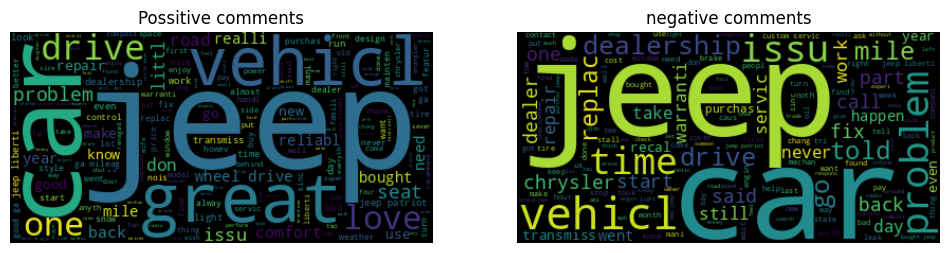

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

# Positive feedback word cloud:
wordcloudnn = WordCloud().generate(pt)
ax1.imshow(wordcloudnn, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Possitive comments')

# Negative comments word cloud:
wordcloudnn = WordCloud().generate(nt)
ax2.imshow(wordcloudnn, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('negative comments')

plt.show()

## **Data Split for Train, Validation and Test**

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1,stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.5, shuffle=True, random_state=1, stratify=y_val_and_test)

print('X,y Train:', len(x_train), len(y_train))      # los "x_" son "list" y los "y_" son "Series"
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 356 356
X,y Val: 76 76
X,y Test 77 77


In [13]:
from collections import Counter
train_label_count = Counter(y_train)
test_label_count = Counter(y_test)
val_label_count = Counter(y_val)

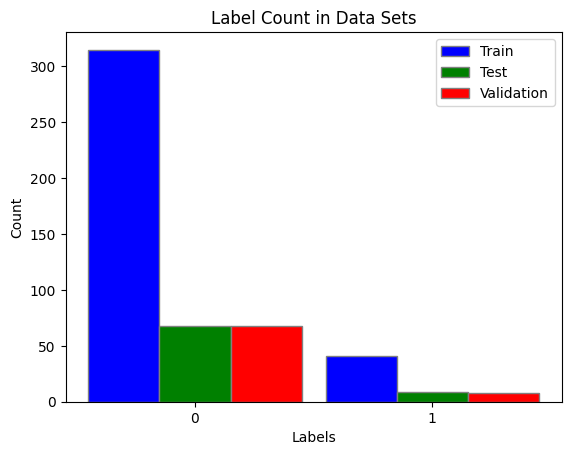

In [14]:
# Convert counts into lists of values
labels = list(train_label_count.keys())
train_counts = list(train_label_count.values())
test_counts = list(test_label_count.values())
val_counts = list(val_label_count.values())

# Define the width of the bars
bar_width = 0.3

# Adjust the position of the bars
r1 = range(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
plt.bar(r1, train_counts, color='blue', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, test_counts, color='green', width=bar_width, edgecolor='grey', label='Test')
plt.bar(r3, val_counts, color='red', width=bar_width, edgecolor='grey', label='Validation')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Count in Data Sets')
plt.xticks([r + bar_width for r in range(len(labels))], labels)
plt.legend()

# Show the plot
plt.show()

## **Vocabulary creation and Filtration:**

In this step let's create a first vocabulary using only the training data. This data is used to avoid information leakage (data leak).

### **Vocabulary creation**

In [15]:
#We create a first vocabulary, which will not be cut so as not to lose information

from collections import Counter

vocab = Counter() #Vocabulario

for k in range(len(x_train)):
 vocab.update(x_train[k])

print('Training dictionary length:', len(vocab))
print('\n(word,frequency):')
print(vocab.most_common(100))


Training dictionary length: 3095

(word,frequency):
[('jeep', 1008), ('not', 608), ('car', 520), ('vehicl', 334), ('problem', 287), ('time', 276), ('would', 266), ('no', 254), ('get', 243), ('drive', 239), ('dealership', 236), ('chrysler', 228), ('issu', 226), ('back', 224), ('mile', 217), ('replac', 202), ('new', 199), ('servic', 198), ('told', 188), ('fix', 177), ('dealer', 174), ('go', 171), ('call', 166), ('light', 163), ('one', 162), ('year', 160), ('warranti', 156), ('purchas', 144), ('part', 139), ('start', 137), ('could', 134), ('never', 133), ('day', 133), ('engin', 131), ('work', 131), ('repair', 129), ('said', 129), ('like', 127), ('transmiss', 124), ('need', 124), ('bought', 121), ('window', 119), ('month', 119), ('custom', 113), ('took', 108), ('also', 108), ('take', 107), ('went', 105), ('liberti', 105), ('still', 104), ('buy', 102), ('week', 101), ('even', 101), ('come', 99), ('anoth', 97), ('happen', 96), ('know', 95), ('recal', 92), ('make', 91), ('don', 89), ('two', 8

**Note:** This additional step is to eliminate words with a frecuency 1 to avoid creating sparse matrices, since as the dictionary grows so will the matrices. The above would cause the model to be overtrained.

In [16]:
#Considers a minimum frequency appropriate for the project

min_freq = 2

midicc = {k: v for k, v in vocab.items() if v >= min_freq}

print('New length of new vocabulary:', len(midicc))
print(list(midicc.items())[0:5]) # let's look at some dictionary items.

New length of new vocabulary: 1859
[('feel', 43), ('bad', 62), ('write', 10), ('bought', 121), ('jeep', 1008)]


### **Filtration**

Let's filter the Train, Validation and Test sets with respect to the new proposed vocabulary

In [17]:
#Function to filter new vocabulary

def filter_out_empty_comments(doc: list, y: list) -> tuple:
    filter_list = [False if line == [] else True for line in doc]
    filtered_doc = np.array(doc, dtype=object)[filter_list]
    filtered_y = np.array(y, dtype = int)[filter_list]

    return (filtered_doc, filtered_y)

In [18]:
train_x = []
for ss in x_train:
  train_x.append([w for w in ss if w in midicc])

val_x = []
for ss in x_val:
  val_x.append([w for w in ss if w in midicc])

test_x = []
for ss in x_test:
  test_x.append([w for w in ss if w in midicc])

train_x, y_train = filter_out_empty_comments(train_x, y_train)
val_x, y_val = filter_out_empty_comments(val_x, y_val)
test_x, y_test = filter_out_empty_comments(test_x, y_test)

#Review output
for k in range(3):
  print('before:', x_train[k])
  print('after:', train_x[k])

before: ['feel', 'bad', 'write', 'bought', 'jeep', 'compass', 'back', 'march', 'rout', 'jeep', 'dealership', 'littl', 'fall', 'nj', 'not', 'go', 'dealership', 'terribl', 'wait', 'hour', 'found', 'vehicl', 'inquir', 'financ', 'guy', 'alex', 'aw', 'give', 'detail', 'loan', 'rush', 'basic', 'didn', 'care', 'best', 'told', 'compass', 'certifi', 'went', 'sign', 'paper', 'not', 'amount', 'quot', 'onlin', 'sale', 'price', 'pay', 'addit', 'certifi', 'fee', 'not', 'disclos', 'mention', 'paperwork', 'sat', 'financ', 'person', 'last', 'minut', 'unprofession', 'wait', 'speak', 'manag', 'dealership', 'left', 'conveni', 'unavail', 'hour', 'next', 'issu', 'car', 'servic', 'morgantown', 'wv', 'dealership', 'octob', 'june', 'car', 'stall', 'vehicl', 'tow', 'white', 'plain', 'ny', 'dealership', 'issu', 'morgantown', 'dealership', 'left', 'screw', 'torqu', 'plate', 'car', 'punch', 'hole', 'motor', 'transmiss', 'find', 'part', 'not', 'come', 'octob', 'without', 'vehicl', 'june', 'not', 'get', 'car', 'octo

# **Text Encoding or Text representation**

Text representation in NLP involves transforming raw text data into a format that machine learning models can understand and process effectively.

For this project we will compare 3 Techniques:

- Cont Vectorizer.
- TF-IDF (Term Frequency-Inverse Document Frequency).
- Word Embeddings -> Embedded FastText vectors pre-trained by Facebook.

## **Count vectorizer**
The count vectorizer is a way to represent text in natural language processing that converts a collection of documents into a document-word matrix. Encoding is therefore done at the document level, rather than at the token level.

Being a bag-of-words model, information regarding the position of the tokens or their context is not encoded, only information about whether they appear and their frequency.

In [20]:
# Let's get the counting arrays
train_x_docs = []
for k in range(len(train_x)):
  train_x_docs.append(' '.join(train_x[k]))

val_x_docs = []
for k in range(len(val_x)):
  val_x_docs.append(' '.join(val_x[k]))

test_x_docs = []
for k in range(len(test_x)):
  test_x_docs.append(' '.join(test_x[k]))


# let's verify that the first Train comments are each as a single string:
for k in range(3):
  print(train_x_docs[k])


feel bad write bought jeep compass back march rout jeep dealership littl fall nj not go dealership terribl wait hour found vehicl financ guy aw give detail loan rush basic didn care best told compass certifi went sign paper not amount quot onlin sale price pay addit certifi fee not mention paperwork sat financ person last minut unprofession wait speak manag dealership left conveni unavail hour next issu car servic morgantown dealership octob june car stall vehicl tow white plain ny dealership issu morgantown dealership left screw torqu plate car motor transmiss find part not come octob without vehicl june not get car octob jeep not help issu jeep fault noth help frustrat never buy jeep
pick new jeep nav sy incomplet took back dealer sold told long period nav sy would live jeep grand last one paid lot money nav system get screw stuck system useless
overal experi don love jeep reliabl enough jeep design featur appeal heat seat sunroof lot extra nice look also rim connect phone radio dura

In [21]:
#let make the dicc to a list
mivocab = list(midicc.keys())

In [25]:
# let's generate the required sparse matrices based on the token count:
from sklearn.feature_extraction.text import CountVectorizer

countvectorizer = CountVectorizer(vocabulary=mivocab)
train_x_count = countvectorizer.fit_transform(train_x_docs)
val_x_count = countvectorizer.transform(val_x_docs)
test_x_count = countvectorizer.transform(test_x_docs)

count_tokens = countvectorizer.get_feature_names_out()
df_countvect = pd.DataFrame(data = train_x_count.toarray(),  columns = count_tokens)
print(df_countvect.iloc[0:3,6:18])

   back  march  rout  dealership  littl  fall  nj  not  go  terribl  wait  \
0     1      1     1           6      1     1   1    6   1        1     2   
1     1      0     0           0      0     0   0    0   0        0     0   
2     1      0     0           0      1     0   0    0   1        0     0   

   hour  
0     2  
1     0  
2     0  


In [24]:
p_sparse = 1 - train_x_count.count_nonzero() / (train_x_count.shape[0] * train_x_count.shape[1])    # Sparsity : % of values in 0.
print('Percent of zero values of the training sparse matrix: %.1f%%' % (100*p_sparse))

Percent of zero values of the training sparse matrix: 96.8%


## **2-TF-IDF Score Vectorizer**

In populating the Document-Term Matrix with the number of occurrences, frequently occurring terms are assigned a higher score than the rarely occurring terms.

TF-IDF score is a combination of two metrics: the Term Frequency (TF) and the Inverse Document Frequency (IDF).

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(vocabulary=mivocab)

#Entrenamiento del modelo en train
train_x_tfidf = tfid.fit_transform(train_x_docs)
val_x_tfidf = tfid.transform(val_x_docs)

#Resultados del entrenamiento
tfidf_tokens = tfid.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = train_x_tfidf.toarray(),  columns = tfidf_tokens)
print(df_tfidfvect.iloc[0:3,6:18])

#Realizamos el entrenamiento en test
test_x_tfidf = tfid.transform(test_x_docs)


       back     march      rout  dealership     littl      fall        nj  \
0  0.041543  0.096358  0.118975    0.263449  0.083265  0.085842  0.108459   
1  0.071199  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
2  0.061338  0.000000  0.000000    0.000000  0.122940  0.000000  0.000000   

        not        go   terribl      wait      hour  
0  0.173089  0.043032  0.090436  0.121295  0.134509  
1  0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.000000  0.063537  0.000000  0.000000  0.000000  


## **3-Embedded FastText vectors pre-trained by Facebook.**
FastText is a Gensim model used to perform word embedding and classification. In it, supervised and unsupervised learning algorithms are created that are used to obtain vector representations of words.

In [30]:
ft = fasttext.load_model('/content/cc.en.300.bin')

In [34]:
fast_text_voca = {}

for w in range(len(mivocab)):
  fast_text_voca[mivocab[w]] = ft.get_word_vector(mivocab[w]) # Variable where the vocabulary generated by FastText is stored.
## Save dictionary to an npy file.
np.save('fast_text_voca.npy', fast_text_voca)

In [35]:
# Remove comments if you want to load the dictionary created with the 300 embedded vectors.

import numpy as np
##Reading the npy file.
#fast_text_voca = np.load('fast_text_voca.npy', allow_pickle='TRUE')
#fast_text_voca=fast_text_voca.item()  # Se convierte la variable de numpy array a diccionario.
print("Number of tokens:",len(fast_text_voca))
print("Number of pre-trained embedded vectors of the word 'much':",len(fast_text_voca.get('much')))

Number of tokens: 1859
Number of pre-trained embedded vectors of the word 'much': 300


In [36]:
trainEmb = []
for ss in train_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  trainEmb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
trainEmb=np.array(trainEmb)# convert to matrix

valEmb = []
for ss in val_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  valEmb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
valEmb=np.array(valEmb)# convert to matrix

testEmb = []
for ss in test_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  testEmb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
testEmb=np.array(testEmb)# convert to matrix


print("Training set dimensions:",trainEmb.shape)
print("Validation set dimensions:",valEmb.shape)
print("Test set dimensions",testEmb.shape)


Training set dimensions: (356, 300)
Validation set dimensions: (76, 300)
Test set dimensions (77, 300)


# **Machine Learning Models**

Logistic Regression and Random Forest will be used to evaluate the 3 text encoding conditions:

In [166]:
# Machine learning models with Count Vectorizer
LR_model_count=LogisticRegression(C=0.05, penalty='l2', solver= 'liblinear',max_iter=400,class_weight= 'balanced' )
LR_model_count.fit(train_x_count,y_train)
RF_model_count = RandomForestClassifier(criterion='gini',max_depth=10,min_samples_split=50,min_samples_leaf=3,max_features='log2',n_jobs=-1,max_samples=0.0666,random_state=10,class_weight= 'balanced' )
RF_model_count.fit(train_x_count,y_train)

# Machine learning models with TF-IDF Score Vectorizer:
LR_model_tfidf=LogisticRegression(C=0.05, penalty='l2', solver= 'liblinear',max_iter=10,class_weight= 'balanced' )
LR_model_tfidf.fit(train_x_tfidf,y_train)
RF_model_tfidf = RandomForestClassifier(criterion='gini',max_depth=10,min_samples_split=50,min_samples_leaf=3,max_features='log2',n_jobs=-1,max_samples=0.0666,random_state=10,class_weight= 'balanced')
RF_model_tfidf.fit(train_x_tfidf,y_train)

#Machine learning model with fastText" embedded vectors
LR_model_emb = LogisticRegression(C=0.05, penalty='l2', solver= 'liblinear',max_iter=400,class_weight= 'balanced' )
LR_model_emb.fit(trainEmb,y_train)
RF_model_emb= RandomForestClassifier(criterion='gini',max_depth=1,min_samples_split=10,min_samples_leaf=1,max_features='log2',n_jobs=-1,max_samples=300,random_state=10,class_weight= 'balanced' )
RF_model_emb.fit(trainEmb,y_train)

#REsults with Count Vectorizer
print('Results using "Count Vectorizer"')
print('Results Logistic Regression:')
print('LR_count: Train-accuracy: %.2f%%' % (100*LR_model_count.score(train_x_count, y_train)))
print('LR_count: Val-accuracy: %2.f%%' % (100*LR_model_count.score(val_x_count, y_val)))
print('Results Random Forest:')
print('RF_count: Train-accuracy: %.2f%%' % (100*RF_model_count.score(train_x_count, y_train)))
print('RF_count: Val-accuracy: %.2f%%' % (100*RF_model_count.score(val_x_count, y_val)))

print('\nResults using "TF-IDF Score Vectorizer"')
print('Results Logistic Regression:')
print('LR_tfidf: Train-accuracy: %.2f%%' % (100*LR_model_tfidf.score(train_x_tfidf, y_train)))
print('LR_tfidf: Val-accuracy: %2.f%%' % (100*LR_model_tfidf.score(val_x_tfidf, y_val)))
print('Results Random Forest:')
print('RF_tfidf: Train-accuracy: %.2f%%' % (100*RF_model_tfidf.score(train_x_tfidf, y_train)))
print('RF_tfidf: Val-accuracy: %.2f%%' % (100*RF_model_tfidf.score(val_x_tfidf, y_val)))

#REsults with fastText" embedded vectors
print('\nResults using "fastText" embedded vectors')
print('Results Logistic Regression:')
print('LR_emb: Train-accuracy: %.2f%%' % (100*LR_model_emb.score(trainEmb, y_train)))
print('LR_emb: Val-accuracy: %2.f%%' % (100*LR_model_emb.score(valEmb, y_val)))
print('Results Random Forest:')
print('RF_emb: Train-accuracy: %.2f%%' % (100*RF_model_emb.score(trainEmb, y_train)))
print('RF_emb: Val-accuracy: %.2f%%' % (100*RF_model_emb.score(valEmb, y_val)))

Results using "Count Vectorizer"
Results Logistic Regression:
LR_count: Train-accuracy: 98.60%
LR_count: Val-accuracy: 87%
Results Random Forest:
RF_count: Train-accuracy: 88.48%
RF_count: Val-accuracy: 89.47%

Results using "TF-IDF Score Vectorizer"
Results Logistic Regression:
LR_tfidf: Train-accuracy: 96.91%
LR_tfidf: Val-accuracy: 92%
Results Random Forest:
RF_tfidf: Train-accuracy: 88.48%
RF_tfidf: Val-accuracy: 89.47%

Results using "fastText" embedded vectors
Results Logistic Regression:
LR_emb: Train-accuracy: 91.29%
LR_emb: Val-accuracy: 84%
Results Random Forest:
RF_emb: Train-accuracy: 93.82%
RF_emb: Val-accuracy: 90.79%


# **Machine learning models evaluation**


## **Results using Count Vectorizer**


Confusion matrix for Logistic Regression (RL) Count Vectorizer
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        68
           1       0.83      0.56      0.67         9

    accuracy                           0.94        77
   macro avg       0.89      0.77      0.82        77
weighted avg       0.93      0.94      0.93        77



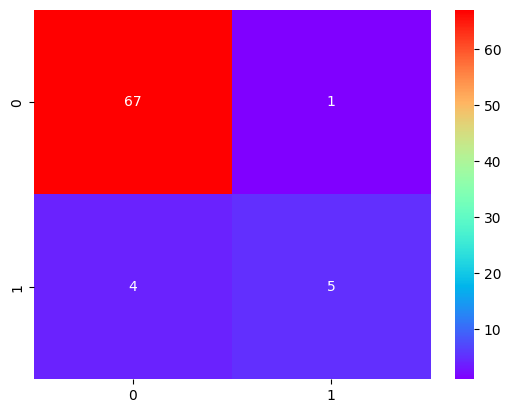

In [167]:
y_pred_LR = LR_model_tfidf.predict(test_x_count)
cm_LR = confusion_matrix(y_test,y_pred_LR)
sns.heatmap(cm_LR, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Logistic Regression (RL) Count Vectorizer")
print(classification_report(y_test,y_pred_LR))

Confusion matrix for Random Forest (RF) using fastText embedded vectors
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        68
           1       0.00      0.00      0.00         9

    accuracy                           0.88        77
   macro avg       0.44      0.50      0.47        77
weighted avg       0.78      0.88      0.83        77



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


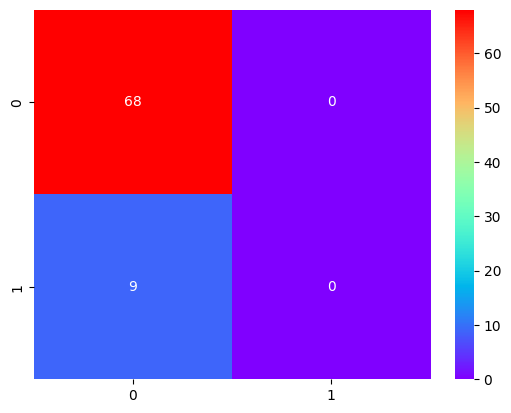

In [168]:

y_pred_RF = RF_model_tfidf.predict(test_x_count)
cm_RF = confusion_matrix(y_test,y_pred_RF)
sns.heatmap(cm_RF, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Random Forest (RF) using fastText embedded vectors")
print(classification_report(y_test,y_pred_RF))


## **Results using TF-IDF Score Vectorizer**


Confusion matrix for Logistic Regression (RL) TF-IDF Score Vectorizer
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        68
           1       1.00      0.56      0.71         9

    accuracy                           0.95        77
   macro avg       0.97      0.78      0.84        77
weighted avg       0.95      0.95      0.94        77



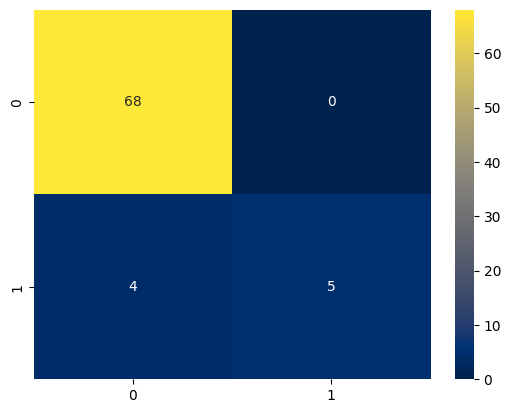

In [169]:
y_pred_LR = LR_model_tfidf.predict(test_x_tfidf)
cm_LR = confusion_matrix(y_test,y_pred_LR)
sns.heatmap(cm_LR, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Logistic Regression (RL) TF-IDF Score Vectorizer")
print(classification_report(y_test,y_pred_LR))

Confusion matrix for Random Forest (RF) using fastText embedded vectors
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        68
           1       0.00      0.00      0.00         9

    accuracy                           0.88        77
   macro avg       0.44      0.50      0.47        77
weighted avg       0.78      0.88      0.83        77



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


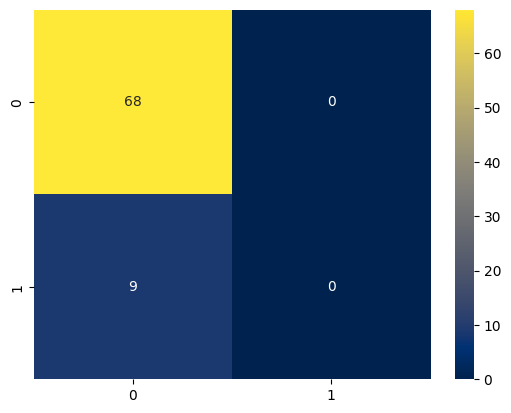

In [170]:

y_pred_RF = RF_model_tfidf.predict(test_x_tfidf)
cm_RF = confusion_matrix(y_test,y_pred_RF)
sns.heatmap(cm_RF, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Random Forest (RF) using fastText embedded vectors")
print(classification_report(y_test,y_pred_RF))


## **Results using FastText Embeddbings**


Confusion matrix for Logistic Regression (RL) using fastText embedded vectors
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        68
           1       0.64      0.78      0.70         9

    accuracy                           0.92        77
   macro avg       0.80      0.86      0.83        77
weighted avg       0.93      0.92      0.93        77



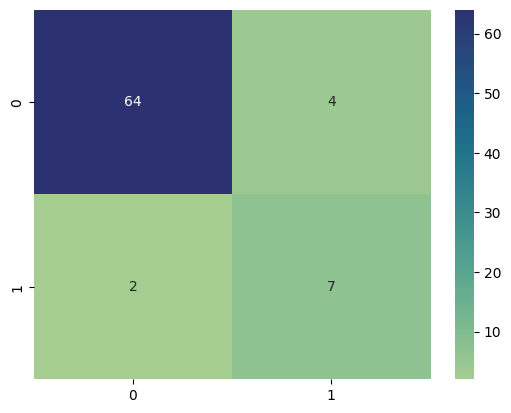

In [171]:
y_pred_LR = LR_model_emb.predict(testEmb)
cm_LR = confusion_matrix(y_test,y_pred_LR)
sns.heatmap(cm_LR, annot=True, fmt = "d",cmap="crest")
print("Confusion matrix for Logistic Regression (RL) using fastText embedded vectors")
print(classification_report(y_test,y_pred_LR))

Confusion matrix for Random Forest (RF) using fastText embedded vectors
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        68
           1       0.83      0.56      0.67         9

    accuracy                           0.94        77
   macro avg       0.89      0.77      0.82        77
weighted avg       0.93      0.94      0.93        77



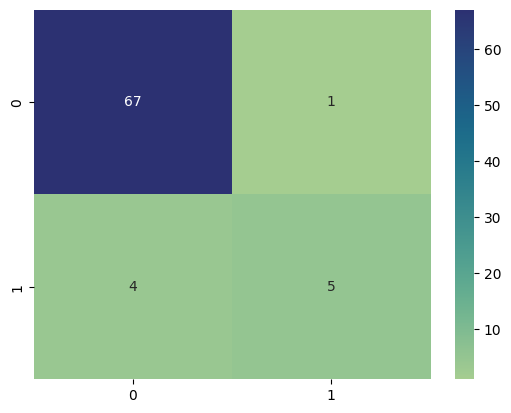

In [172]:

y_pred_RF = RF_model_emb.predict(testEmb)
cm_RF = confusion_matrix(y_test,y_pred_RF)
sns.heatmap(cm_RF, annot=True, fmt = "d",cmap="crest")
print("Confusion matrix for Random Forest (RF) using fastText embedded vectors")
print(classification_report(y_test,y_pred_RF))


# **Conclusions:**



For this part of the project, data cleaning and preprocessing was carried out using different methods.

Cleaning:
- Stop words elimination: Elimination of stopwords and negwords.
- Capital letters, spaces, and special characters. (Using REGEX)
- Elimination of double or more spaces. (Using REGEX)
- Uppercase to lowercase conversion.
Tokenization.
 Stemming.  (Using PorterStemmer() )
- Elimination of tokens greater than 1.

The next was to check with a word cloud the positive and negative comments.
Then we split the data for train validation and test. After we build the vocabulary and then create final text filtration to eliminate all the words that were not contain in our vocabulary.

Text representation or text encoding that we can associate with the data transformation 3 methods were used.

- Count vectorizer. (Document-Term Matrix (DTM))
- TF-IDF Score Vectorizer.
- Embedded fastText vectors pre-trained by Facebook.

3 methods were selected for text representation to compare results using 2 Machine learning (Random Forest and Logistic regression).

3 methods were tested but we find that data labels imbalance provokes that machine learning methods were not good to predict a positive comment the best combination that presented a good performance was using embeddings fasttext activating the class weight = ‘balanced’ parameter in the model.

Comparing the 6  results we can see that values that are very close indicate that the model was not able to detect positive comments in the validation data or test data.

The 2 best results analized with the confusion matrix were the following:

- Logistic Regression (RL) using fastText embedded vectors.
- Logistic Regression (RL) TF-IDF Score Vectorizer.

For next steps we will work in the fine tuning of models parameters and study better tools to balance the data.

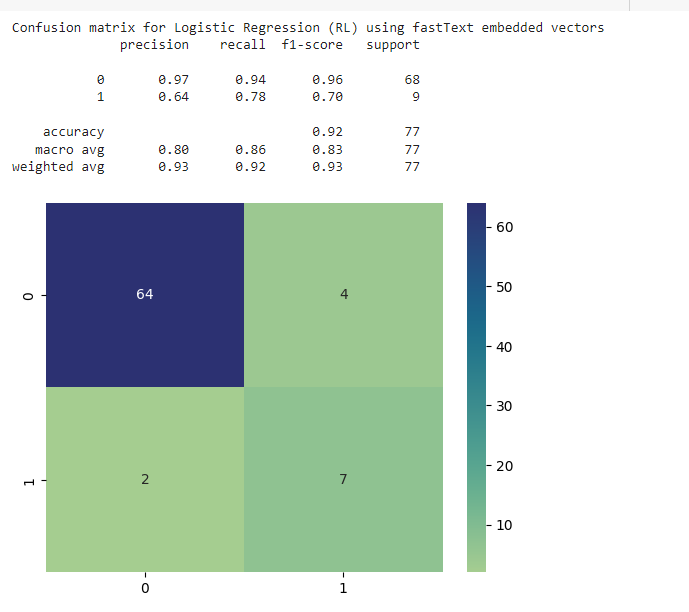

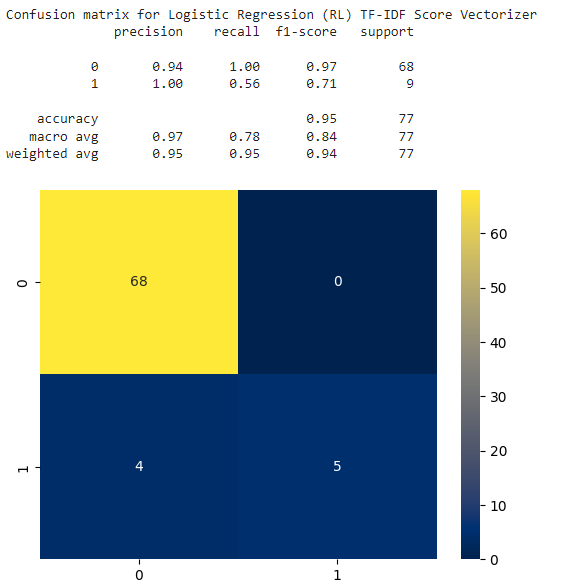

# **References:**
- ParseHub. (n.d.). What Is Web Scraping? | ParseHub. ParseHub. Retrieved January 28, 2024, from https://www.parsehub.com/blog/what-is-web-scraping/

- Falcón Morales, L. E. (2023). Maestría en Inteligencia Artificial Aplicada. ITESM

- Kumar Mukhiya, S., y Ahmed, U. (2020). Hands-On Exploratory Data Analysis with Python. Packt Publishing.

- Falcón Morales, L. E. (2023). Expresiones regulares (regex). Maestría en Inteligencia Artificial Aplicada. ITESM.

- KeepCoding. (2023). ¿Qué es el count vectorizer?. https://keepcoding.io/blog/que-es-el-count-vectorizer/#:~:text=El%20count%20vectorizer%20es%20una,de%20a%20nivel%20de%20token.

- KeepCoding. (2023). ¿Qué es el TF-IDF Vectorizer?. https://keepcoding.io/blog/que-es-el-algoritmo-tf-idf-vectorizer/#:~:text=El%20TF%2DIDF%20tiene%20en,de%20TF%2DIDF%20Vectorizer%20bajo.

- Facebook. (2022). Get started. https://fasttext.cc/docs/en/support.html

- Introduction to word embeddings – word2vec, glove, FastText and Elmo. Data Science Machine Learning Deep Learning. (n.d.). https://www.alpha-quantum.com/blog/word-embeddings/introduction-to-word-embeddings-word2vec-glove-fasttext-and-elmo/